<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа» - Ускорение тестирования</b></h3>


## Импорт библиотек

In [219]:
import numpy as np
import pandas as pd

import scipy
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Импорт данных

In [220]:
data_path = "https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/SkillBox/ab_speedup.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (50000, 2)


,group,metrica
strata,,
11,history,42.631346
6,history,14.844453
4,history,2.362768
37,history,79.494017
18,history,-22.627788
34,history,28.679378


In [221]:
data.nunique()

group          3
metrica    50000
dtype: int64

In [222]:
data.index.nunique()

50

In [223]:
data.group.unique()

array(['history', 'B', 'A'], dtype=object)

<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой результаты некоторого А/B-Теста. 

* `strata` - Некоторая информация по страту (группа), к которой относится пользователь. 
* `group` - Группа эксперимента - тестовая, контрольная или прошлая история. 
* `metrica` - Целивая метрика
    
</div>

<div class="alert alert-info">

<b>Задание:</b>    
    
Найти различие между группами, увеличив чувствительность тестов тремя способами поочередно:
* Бутстрап
* Стратификация
* CUPED
    
Вспомогательная статья Валерия Бабушкина про стратификацию и CUPED:

* habr.com/ru/company/yandex/blog/497804/

## Бутстрап

Этот метод использует подход к повторной выборке для оценки статистической неопределенности. Поскольку этот метод включает в себя большое количество повторений, он может обеспечить более точные оценки, чем простой t-тест. Если p-значение меньше 0,05, это может указывать на статистически значимые различия между группами A и B. Однако этот метод все еще может быть подвержен выбросам, так как он берет случайные примеры из каждой группы

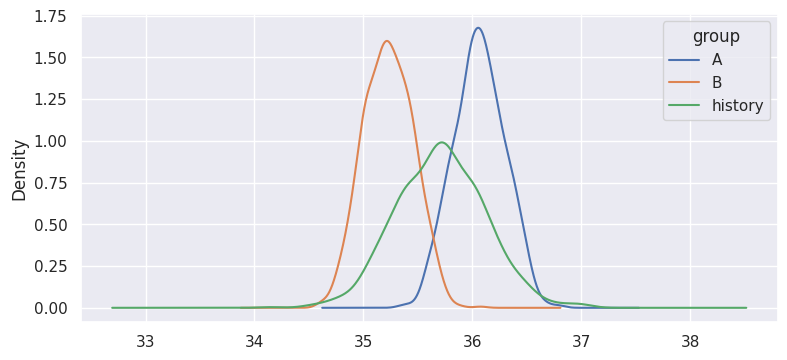

Статистика = 0.998, p = 0.251
Нормальное распределение (не отвергаем H0)
Статистика = 0.997, p = 0.068
Нормальное распределение (не отвергаем H0)
Средние значения:
group            A          B    history
metrica  36.455719  35.131269  34.514890
metrica  35.985570  34.994657  36.079637
metrica  36.222732  35.269655  35.625502
metrica  35.637012  35.273094  36.530663
metrica  36.242048  34.947597  35.742749
...            ...        ...        ...
metrica  36.084740  34.941524  36.105761
metrica  36.190961  35.313397  36.373213
metrica  36.040038  35.025265  35.224566
metrica  35.990890  35.049540  35.662390
metrica  36.243967  35.115919  35.751922

[1000 rows x 3 columns]
Дисперсии:
group              A            B      history
metrica  1186.895722  1151.823620  1171.549676
metrica  1185.907303  1144.668351  1167.293405
metrica  1178.378001  1149.399543  1200.917277
metrica  1195.746183  1183.855789  1198.810596
metrica  1177.695725  1176.175591  1173.157856
...              ...      

In [224]:
# Функция для проведения теста Шапиро-Уилка и вывода результатов
def shapiro_verbal(data, alpha=0.05):
    statistic, p_value = stats.shapiro(data)
    print(f"Статистика = {statistic:.3f}, p = {p_value:.3f}")
    if p_value > alpha:
        print("Нормальное распределение (не отвергаем H0)")
    else:
        print("Не нормальное распределение (отвергаем H0)")


# Функция для проведения t-теста и вывода результатов
def ttest_ind_verbal(x, y, alternative, accept_h0_verbal, accept_h1_verbal, alpha=0.05):
    statistic, p_value = stats.ttest_ind(x, y, alternative=alternative)
    if p_value > alpha:
        print(accept_h0_verbal)
    else:
        print(accept_h1_verbal)
    print(f"Статистика = {statistic:.3f}, p = {p_value:.3f}")


# Функция для выполнения бутстрап-анализа
def bootstrap_analysis(data, column, iterations=1000):
    bootstrap_means = []
    bootstrap_variances = []  # Список для хранения дисперсий
    for _ in range(iterations):
        sample = data.sample(frac=1, replace=True)
        bootstrap_mean = sample.groupby("group")[column].mean()
        bootstrap_means.append(bootstrap_mean)
        bootstrap_variance = sample.groupby("group")[column].var()  # Вычисление дисперсии
        bootstrap_variances.append(bootstrap_variance)
    return pd.DataFrame(bootstrap_means), pd.DataFrame(bootstrap_variances)


# Выполняем бутстрап-анализ и получаем средние значения и дисперсии для каждой группы
bootstrapped_means, bootstrapped_variances = bootstrap_analysis(data, "metrica")

# Визуализация распределения средних значений
bootstrapped_means.plot(kind="density", figsize=(9, 4))
plt.show()

# Проверка нормальности распределений групп A и B
shapiro_verbal(bootstrapped_means["A"])
shapiro_verbal(bootstrapped_means["B"])

# Вывод средних значений и дисперсий
print("Средние значения:")
print(bootstrapped_means)
print("Дисперсии:")
print(bootstrapped_variances)

# Выполняем t-тест на основе бутстрап-анализа
ttest_ind_verbal(
    bootstrapped_means["A"],
    bootstrapped_means["B"],
    alternative='greater',
    accept_h0_verbal="Не отвергаем H0 в о том, что среднее группы A равно среднему группы B",
    accept_h1_verbal="Отвергаем H0 в пользу H1 о том, что среднее группы A больше, чем среднее группы B",
)

In [225]:
# Дисперсии в группах очень малы.
# Тест показал, что среднее группы A больше, чем группы B

## Стратификация

Этот метод разбивает данные на страты или группы и анализирует каждую из них по отдельности. Это может улучшить чувствительность теста, потому что он учитывает структуру внутри данных. Однако результаты могут зависеть от того, как именно вы разделите данные на страты. Если p-значения, полученные для каждой страты, ниже 0,05, это может указывать на статистически значимые различия между группами внутри этих страт

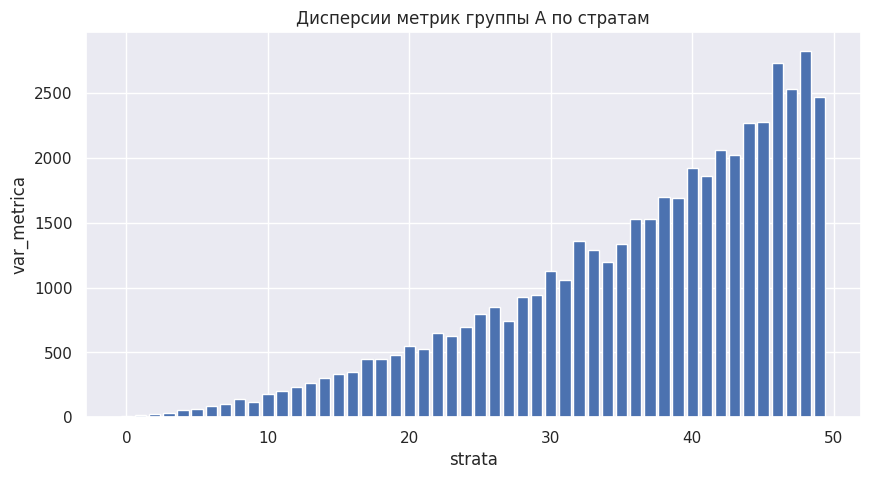

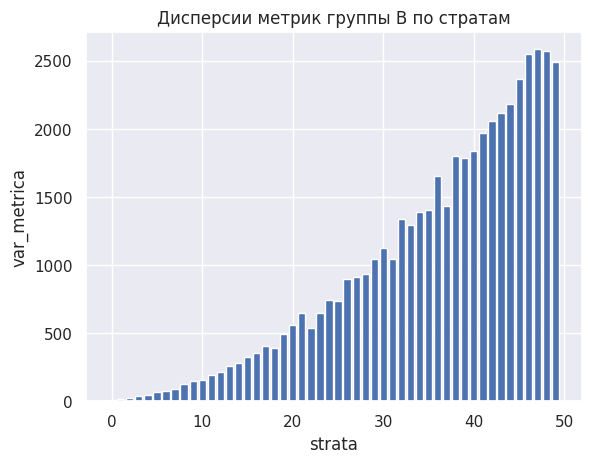

Среднее стратифицированное группы "A": 35.8903783507931
Дисперсия стратифицированного семплирования для группы "A": 970.4027078338117
Среднее стратифицированное группы "B": 35.3299171483245
Дисперсия стратифицированного семплирования для группы "B": 963.9726757176608


,var_metrica,mean
group,,
A,1184.496837,36.057227
B,1165.657875,35.229950
history,1180.056311,35.721627


In [226]:
# Рассчитываем средние и дисперсии для каждой страты
stratified_data = data.groupby(['group', 'strata'])['metrica'].agg(['mean', 'var', 'count']).reset_index()

# Визуализация дисперсий метрик по стратам
plt.figure(figsize=(10, 5))
for group in ['A', 'B']:
    group_data = stratified_data[stratified_data['group'] == group]
    plt.bar(group_data['strata'], group_data['var'])
    plt.xlabel('strata')
    plt.ylabel('var_metrica')
    plt.title(f'Дисперсии метрик группы {group} по стратам')
    plt.show()

# Расчет стратифицированных средних и дисперсий
stratified_means = stratified_data.groupby('group')['mean'].mean()
stratified_vars = stratified_data.groupby('group').apply(lambda x: np.average(x['var'], weights=x['count']))

# Вывод результатов
for group in ['A', 'B']:
    mean_strat = stratified_means[group]
    var_strat = stratified_vars[group]
    print(f'Среднее стратифицированное группы "{group}": {mean_strat}')
    print(f'Дисперсия стратифицированного семплирования для группы "{group}": {var_strat}')

# Расчет дисперсий нестратифицированных метрик
data.groupby('group')['metrica'].agg(['var', 'mean']).rename(columns={'var': 'var_metrica'})

In [227]:
# Дисперсии значительно уменьшились
# Но они больше чем после бутстрапа

## CUPED (Controlled Experiments Using Paired Differences)

CUPED - это метод, который уменьшает вариацию в данных, вычитая предсказуемую часть каждого наблюдения. Это помогает сосредоточиться на интересующей вас переменной и может улучшить чувствительность теста. Если p-значение меньше 0,05, это может указывать на статистически значимые различия между группами A и B после корректировки CUPED.

In [228]:
# Рассчитываем дисперсию методом CUPED для каждой группы
def var_cuped(X, Y):
    theta = Y.cov(X) / X.var()
    result = Y.var() + theta ** 2 * X.var() - 2 * theta * Y.cov(X)
    return result


for group in ['A', 'B']:
    var_cuped_value = var_cuped(data[data['group'] == 'history']['metrica'], data[data['group'] == group]['metrica'])
    print(f'Дисперсия при методе CUPED для выборки {group}: {var_cuped_value}')

# Расчет начальных дисперсий метрик
data.groupby('group')['metrica'].agg(['var', 'mean']).rename(columns={'var': 'var_metrica'})

Дисперсия при методе CUPED для выборки A: 1147.0901608920103
Дисперсия при методе CUPED для выборки B: 1130.6003407527583


,var_metrica,mean
group,,
A,1184.496837,36.057227
B,1165.657875,35.229950
history,1180.056311,35.721627


In [229]:
# Дисперсии незначительно уменьшились,
# CUPED оказался в данном случае не эффективным.
